In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

from Previous_files.utils import create_truck, compute_speed, locate_peaks
from Previous_files.data import read_file, load_senlis
from Previous_files.bwim import *
from Previous_files.plot import compare_weights

In [2]:
def quick_show(meters, signal, peaks=[]):
    plt.plot(meters, signal)
    for p in peaks:
        plt.axvline(meters[p], linestyle='--', color='k', alpha=0.1)

## Original signal

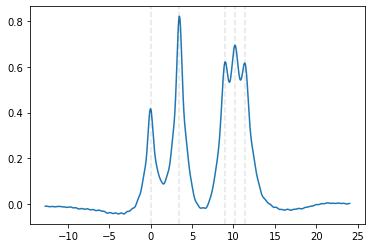

In [3]:
from Bwifsttar import load_senlis_modified
test_trucks, train_trucks = load_senlis_modified(selected=4)

truck = train_trucks[0]
meters = truck.speed * truck.time
meters = meters - meters[truck.peaks[0]]
signal = truck.signals
peaks  = truck.peaks

plt.figure()
quick_show(meters, signal, peaks)
plt.show()

In [4]:
print('Measured axle distance:', np.round(np.diff(meters[truck.peaks]), decimals=2))
print('    Real axle distance:', np.round([3.8, 6., 1.31, 1.31], decimals=2))

Measured axle distance: [3.46 5.54 1.2  1.15]
    Real axle distance: [3.8  6.   1.31 1.31]


## Oversampled signal

In [5]:
meters = truck.speed * truck.time
meters = meters - meters[truck.peaks[0]]
signal = truck.signals

# interpolation
func = interp1d(meters, signal, fill_value="extrapolate")

# over-sampling
new_meters = np.arange(meters.min(), meters.max(), 0.02)
new_signal = func(new_meters)
new_peaks  = locate_peaks(new_signal)

print(signal.size, new_signal.size)

798 1840


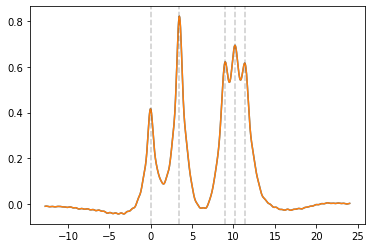

In [6]:
plt.figure()
quick_show(meters, signal, peaks)
quick_show(new_meters, new_signal, new_peaks)
plt.show()

## Code integration

In [7]:
from collections import namedtuple
NewTruck = namedtuple('NewTruck', ['name', 'meters', 'signals', 'peaks', 'weights'])

def create_truck_new(name, events, time_idx, speed_idx, signal_idx, static_weights=None):
    time    = events[time_idx]
    shifted = events[speed_idx]
    signals = events[signal_idx]
    speed   = compute_speed(time, shifted, distance=3)
    peaks   = locate_peaks(signals)
    meters, signals = time_to_meter_conversion(time, signals, speed, peaks)
    peaks   = locate_peaks(signals)
    weights = static_weights[name] if static_weights is not None else None
    truck   = NewTruck(name, meters, signals, peaks, weights)
    return truck

In [8]:
def time_to_meter_conversion(time, signals, speed, peaks, delta=0.02):
    meters = speed * time
    meters = meters - meters[peaks[0]]
    grid = np.arange(meters.min(), meters.max(), delta)
    new_signals = []
    for s in np.atleast_2d(signals):
        func = interp1d(meters, s, fill_value="extrapolate")
        new_s = func(grid)
        new_signals.append(new_s)
    return grid, np.array(new_signals).squeeze()

In [9]:
weights = {'cal_sep_2015': np.array([6.16068,  10.8499, 9.08406, 6.98472, 7.0632])}

events = read_file('data/senlis/calibration/2015-09-29-09-28-46-125.txt')
truck1 = create_truck_new('cal_sep_2015', events, 0, [1,2], 4, weights)

events = read_file('data/senlis/calibration/2015-09-29-09-56-08-457.txt')
truck2 = create_truck_new('cal_sep_2015', events, 0, [1,2], 4, weights)

In [10]:
def show_new(truck):
    plt.plot(truck.meters, truck.signals.T)
    for p in truck.peaks:
        plt.axvline(truck.meters[p], linestyle='--', color='k', alpha=0.2)

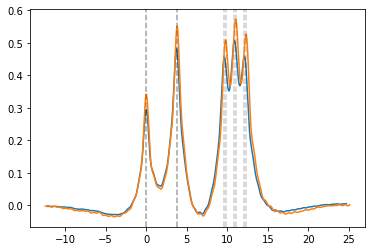

In [11]:
plt.figure()
show_new(truck1)
show_new(truck2)
plt.show()

In [12]:
print('Measured axle distance:', np.round(np.diff(truck1.meters[truck1.peaks]), decimals=2))
print('    Real axle distance:', np.round([3.8, 6., 1.31, 1.31], decimals=2))

Measured axle distance: [3.74 5.9  1.22 1.24]
    Real axle distance: [3.8  6.   1.31 1.31]


In [13]:
print('Measured axle distance:', np.round(np.diff(truck2.meters[truck2.peaks]), decimals=2))
print('    Real axle distance:', np.round([3.8, 6., 1.31, 1.31], decimals=2))

Measured axle distance: [3.8  5.98 1.26 1.28]
    Real axle distance: [3.8  6.   1.31 1.31]


## Resampling the signal over the meter scale.
 - **Pros:** Later operations are simplified, because all signals are aligned on the same scale.
 - **Cons:** Axles misalignement due to errors in speed detection.

## Calibration

In [14]:
def calibration(truck, length, l2_reg=None, tv_reg=None):
    A, b = prepare_least_squares(truck, length)
    A, b = prepare_regularization(A, b, l2_reg, tv_reg)
    influence ,_, _, _ = np.linalg.lstsq(A, b, rcond=None)
    return influence

In [15]:
def reconstruction(truck, influence):
    toeplitz  = create_toeplitz(truck.signals.shape[-1], influence.size, truck.peaks)
    T_matrix  = np.sum(truck.weights[:,None,None] * toeplitz, axis=0)
    predicted = T_matrix @ influence
    return predicted

In [16]:
def estimation(truck, influence):
    toeplitz = create_toeplitz(truck.signals.shape[-1], influence.size, truck.peaks)
    H_matrix = toeplitz @ influence
    w ,_,_,_ = np.linalg.lstsq(H_matrix.T, truck.signals.T, rcond=None)
    return w

In [17]:
def spline_calibration(truck, length, l2_reg=None, tv_reg=None, **kwargs):
    A, b = prepare_least_squares(truck, length)
    A, b = prepare_regularization(A, b, l2_reg, tv_reg)
    rough_influence = extract_first_peak(truck.signals, truck.peaks)
    spline_matrix, _,_ = spline_approximation(rough_influence, length, **kwargs)
    A = A @ spline_matrix
    spline_coefs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    influence = spline_matrix @ spline_coefs
    return influence

In [18]:
def show_calibration(truck, influence):
    recovery = reconstruction(truck, influence)
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    delta = truck.meters[1] - truck.meters[0]
    domain = delta*(np.arange(influence.size) - influence.size//2)
    plt.plot(domain, influence)
    plt.axhline(0, color='k', linewidth=1, zorder=0, alpha=0.1)
    plt.xlabel('Meters')
    plt.subplot(1,2,2)
    plt.plot(truck.meters, recovery, linewidth=2, label='Recovered')
    plt.plot(truck.meters, truck.signals.T, label='Observed', alpha=0.7)
    plt.axhline(0, color='k', linewidth=1, zorder=0, alpha=0.1)
    plt.xlabel('Meters')
    plt.legend()
    plt.show()

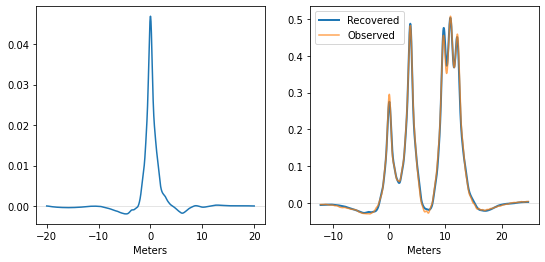

In [19]:
influence = calibration(truck1, length=2001, 
                        l2_reg={'strength': 1e3, 'cutoff': 0.01}, # make sure that tails go to zero
                        tv_reg={'strength': 1e3, 'cutoff': 0.95}) # remove oscillations

#influence = spline_calibration(truck1, length=2001,
#                               l2_reg={'strength': 1e3, 'cutoff': 0.01}, # make sure that tails go to zero
#                               tv_reg={'strength': 1e3, 'cutoff': 0.95}, # remove oscillations
#                               s=1e-4) # tolerance for spline interpolation

show_calibration(truck1, influence)

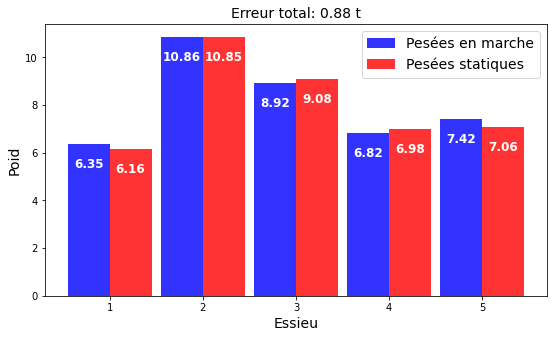

In [20]:
w = estimation(truck1, influence)

compare_weights(w.squeeze(), truck1.weights)

## Cross validation

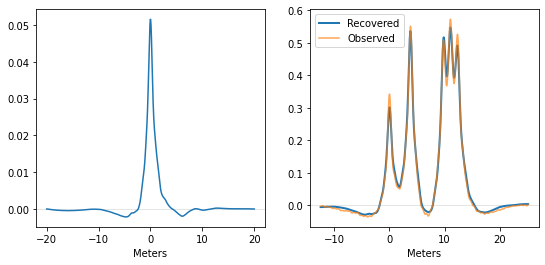

In [21]:
show_calibration(truck2, influence*1.1)

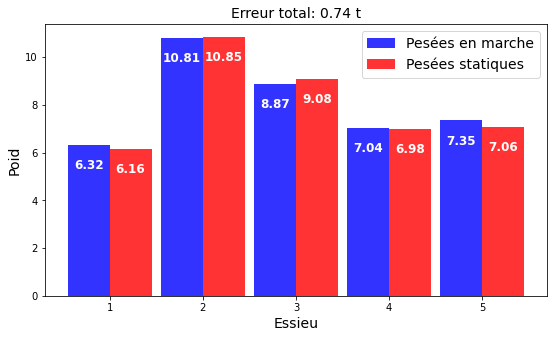

In [22]:
w = estimation(truck2, influence*1.1)

compare_weights(w.squeeze(), truck2.weights)